In [1]:
import os  # interacting with the operating system
import numpy as np  # arithmetic calculations
import pandas as pd  # handling data using dataframes
import matplotlib.pyplot as plt  # plotting data
from Bio import SeqIO  # working with biological sequences
from sklearn.model_selection import train_test_split  # splitting data into train and test sets
from sklearn.feature_extraction.text import TfidfVectorizer  # encoding text data
from sklearn.preprocessing import MinMaxScaler  # data normalization

from tensorflow.keras.models import Sequential  # creating neural network models
# various layers for building neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, ActivityRegularization
from tensorflow.keras.optimizers import Adam  # Adam optimizer for training the model
from tensorflow.keras.callbacks import EarlyStopping  # early stopping during training


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
sequence_path = "covid19/covid_sequences.fasta"
refseq_path = "covid19/reference.fasta"
sequences = {record.id: str(record.seq.lower()) for record in SeqIO.parse(sequence_path, 'fasta')}
refseq = str(SeqIO.read(refseq_path, 'fasta').seq)
print(f"Total Number of sequences: {len(sequences.keys())}")
print(f"Number of bases in reference sequence: {len(refseq)}")

Total Number of sequences: 13990
Number of bases in reference sequence: 29903


In [3]:
covid_df = pd.DataFrame.from_dict({'seqid':sequences.keys(), 'sequences':sequences.values()})
covid_df

,seqid,sequences
0,ON191588.1,tctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgc...
1,ON191589.1,tctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgc...
2,ON191590.1,tctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgc...
3,ON191591.1,tctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgc...
4,ON191592.1,tctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgc...
...,...,...
13985,OX397935.1,nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
13986,OX397936.1,nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
13987,OX397937.1,nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...
13988,OX397938.1,nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...


In [4]:
def kmers(sequence, size=6):
    return " ".join([sequence[x:x+size] for x in range(len(sequence) - size + 1)])

In [5]:
covid_df['kmers'] = covid_df['sequences'].apply(kmers)
covid_df

,seqid,sequences,kmers
0,ON191588.1,tctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgc...,tctaaa ctaaac taaacg aaacga aacgaa acgaac cgaa...
1,ON191589.1,tctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgc...,tctaaa ctaaac taaacg aaacga aacgaa acgaac cgaa...
2,ON191590.1,tctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgc...,tctaaa ctaaac taaacg aaacga aacgaa acgaac cgaa...
3,ON191591.1,tctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgc...,tctaaa ctaaac taaacg aaacga aacgaa acgaac cgaa...
4,ON191592.1,tctaaacgaactttaaaatctgtgtggctgtcactcggctgcatgc...,tctaaa ctaaac taaacg aaacga aacgaa acgaac cgaa...
...,...,...,...
13985,OX397935.1,nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...,nnnnnn nnnnnn nnnnnn nnnnnn nnnnnn nnnnnn nnnn...
13986,OX397936.1,nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...,nnnnnn nnnnnn nnnnnn nnnnnn nnnnnn nnnnnn nnnn...
13987,OX397937.1,nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...,nnnnnn nnnnnn nnnnnn nnnnnn nnnnnn nnnnnn nnnn...
13988,OX397938.1,nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...,nnnnnn nnnnnn nnnnnn nnnnnn nnnnnn nnnnnn nnnn...


In [6]:
stop_codons = ['TAA', 'TAG', 'TGA']
kmer_length = 6

def generate_kmers_with_stop_codons(kmer_length, stop_codons):
    kmers = []
    bases = 'ACGT'

    for first_base in bases:
        for second_base in bases:
            for third_base in bases:
                for fourth_base in bases:
                    for fifth_base in bases:
                        for sixth_base in bases:
                            kmer = first_base + second_base + third_base + fourth_base + fifth_base + sixth_base
                            if kmer[:3] in stop_codons or kmer[-3:] in stop_codons:
                                kmers.append(kmer)

    return kmers

stop_words = generate_kmers_with_stop_codons(kmer_length, stop_codons)

In [7]:
# Merge 'english' and custom stop words into a single list
stop_words = list(TfidfVectorizer(stop_words='english').get_stop_words()) + stop_words
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=4984)

# Fit and transform the abstracts to obtain TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(covid_df['kmers'])
# Get the feature names (words) from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

In [8]:
X = pd.DataFrame(tfidf_matrix.toarray(), columns=list(feature_names))
X

,aaaaaa,aaaaac,aaaaag,aaaaan,aaaaat,aaaaca,aaaacc,aaaacg,aaaacn,aaaact,...,ttttgg,ttttgn,ttttgt,ttttnn,ttttta,tttttc,tttttg,tttttn,tttttt,ycacag
0,0.003196,0.025532,0.035110,0.0,0.025534,0.044682,0.019149,0.003192,0.0,0.027128,...,0.036703,0.0,0.054256,0.0,0.027130,0.027157,0.035145,0.0,0.014377,0.0
1,0.000742,0.005928,0.007781,0.0,0.005558,0.009633,0.004446,0.000371,0.0,0.005928,...,0.008521,0.0,0.012226,0.0,0.005928,0.006676,0.008160,0.0,0.002225,0.0
2,0.002813,0.022473,0.030902,0.0,0.022474,0.039327,0.016855,0.002809,0.0,0.023877,...,0.033709,0.0,0.047755,0.0,0.021070,0.023903,0.032339,0.0,0.012655,0.0
3,0.002086,0.016664,0.022915,0.0,0.016665,0.028121,0.012498,0.002083,0.0,0.017706,...,0.023955,0.0,0.035411,0.0,0.015624,0.017725,0.023980,0.0,0.009384,0.0
4,0.001453,0.011609,0.015963,0.0,0.010884,0.020315,0.007256,0.001451,0.0,0.011609,...,0.017413,0.0,0.024669,0.0,0.011610,0.011621,0.016706,0.0,0.006537,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13985,0.002960,0.023651,0.032522,0.0,0.025131,0.042867,0.017738,0.004435,0.0,0.025129,...,0.032520,0.0,0.048779,0.0,0.025131,0.028115,0.034034,0.0,0.008878,0.0
13986,0.002960,0.023653,0.032525,0.0,0.022176,0.041392,0.017739,0.004435,0.0,0.025131,...,0.034001,0.0,0.050262,0.0,0.025133,0.028118,0.035517,0.0,0.008879,0.0
13987,0.001305,0.010423,0.014333,0.0,0.011075,0.018240,0.007817,0.001954,0.0,0.011074,...,0.014331,0.0,0.020846,0.0,0.011075,0.012390,0.014347,0.0,0.003261,0.0
13988,0.001337,0.010016,0.014692,0.0,0.010685,0.018030,0.008013,0.002003,0.0,0.011352,...,0.015359,0.0,0.021368,0.0,0.010685,0.012701,0.016044,0.0,0.004011,0.0


In [9]:
del sequences, covid_df

In [10]:
Y = pd.concat([X.iloc[1:, :], X.iloc[[0], :]], axis=0)
Y.index = range(Y.shape[0])
Y

,aaaaaa,aaaaac,aaaaag,aaaaan,aaaaat,aaaaca,aaaacc,aaaacg,aaaacn,aaaact,...,ttttgg,ttttgn,ttttgt,ttttnn,ttttta,tttttc,tttttg,tttttn,tttttt,ycacag
0,0.000742,0.005928,0.007781,0.0,0.005558,0.009633,0.004446,0.000371,0.0,0.005928,...,0.008521,0.0,0.012226,0.0,0.005928,0.006676,0.008160,0.0,0.002225,0.0
1,0.002813,0.022473,0.030902,0.0,0.022474,0.039327,0.016855,0.002809,0.0,0.023877,...,0.033709,0.0,0.047755,0.0,0.021070,0.023903,0.032339,0.0,0.012655,0.0
2,0.002086,0.016664,0.022915,0.0,0.016665,0.028121,0.012498,0.002083,0.0,0.017706,...,0.023955,0.0,0.035411,0.0,0.015624,0.017725,0.023980,0.0,0.009384,0.0
3,0.001453,0.011609,0.015963,0.0,0.010884,0.020315,0.007256,0.001451,0.0,0.011609,...,0.017413,0.0,0.024669,0.0,0.011610,0.011621,0.016706,0.0,0.006537,0.0
4,0.003192,0.025502,0.035067,0.0,0.025503,0.044628,0.019126,0.003188,0.0,0.027095,...,0.039846,0.0,0.052597,0.0,0.025503,0.030316,0.035102,0.0,0.009573,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13985,0.002960,0.023653,0.032525,0.0,0.022176,0.041392,0.017739,0.004435,0.0,0.025131,...,0.034001,0.0,0.050262,0.0,0.025133,0.028118,0.035517,0.0,0.008879,0.0
13986,0.001305,0.010423,0.014333,0.0,0.011075,0.018240,0.007817,0.001954,0.0,0.011074,...,0.014331,0.0,0.020846,0.0,0.011075,0.012390,0.014347,0.0,0.003261,0.0
13987,0.001337,0.010016,0.014692,0.0,0.010685,0.018030,0.008013,0.002003,0.0,0.011352,...,0.015359,0.0,0.021368,0.0,0.010685,0.012701,0.016044,0.0,0.004011,0.0
13988,0.002959,0.023644,0.032513,0.0,0.025124,0.042855,0.017733,0.004434,0.0,0.025122,...,0.032510,0.0,0.047288,0.0,0.026601,0.028107,0.032545,0.0,0.011835,0.0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [12]:
X_train.shape

(11192, 4984)

In [13]:
# Normalize the data for better LSTM performance
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
X_train_scaled.shape

(11192, 4984)

In [15]:
X_test_scaled.shape

(2798, 4984)

In [16]:
# Reshape the data for LSTM input (samples, timesteps, features)
# Assuming your sequences have a fixed length, e.g., 10 time steps
seq_length = 1
num_features = X_train.shape[1]  # Number of features in your original data

X_train_reshaped = X_train_scaled.reshape(-1, seq_length, num_features)
X_test_reshaped = X_test_scaled.reshape(-1, seq_length, num_features)

In [17]:
# Build an efficient LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(seq_length, X_train.shape[1]), activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(units=32, activation='relu', return_sequences=True, kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(units=16, activation='relu', return_sequences=True, kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(units=8, activation='relu', kernel_regularizer='l2'))
model.add(Dense(X_train.shape[1], activation='linear'))  # Output layer


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             1292544   
                                                                 
 batch_normalization (BatchN  (None, 1, 64)            256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             12416     
                                                                 
 batch_normalization_1 (Batc  (None, 1, 32)            128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1, 32)             0

In [19]:
# Compile the model with adjusted learning rate and metrics
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy', 'mae'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

In [20]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=500, batch_size=32, validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

Epoch 1/500
350/350 [==============================] - 16s 25ms/step - loss: 0.2891 - accuracy: 0.2691 - mae: 0.0028 - val_loss: 0.0085 - val_accuracy: 0.2913 - val_mae: 0.0020
Epoch 2/500
350/350 [==============================] - 8s 22ms/step - loss: 0.0017 - accuracy: 0.2943 - mae: 0.0021 - val_loss: 8.1996e-05 - val_accuracy: 0.2913 - val_mae: 0.0022
Epoch 3/500
350/350 [==============================] - 8s 22ms/step - loss: 4.8824e-05 - accuracy: 0.2943 - mae: 0.0021 - val_loss: 4.2273e-05 - val_accuracy: 0.2913 - val_mae: 0.0022
Epoch 4/500
350/350 [==============================] - 8s 22ms/step - loss: 4.2537e-05 - accuracy: 0.2943 - mae: 0.0021 - val_loss: 4.2156e-05 - val_accuracy: 0.2913 - val_mae: 0.0022
Epoch 5/500
350/350 [==============================] - 8s 23ms/step - loss: 4.2521e-05 - accuracy: 0.2943 - mae: 0.0021 - val_loss: 4.2133e-05 - val_accuracy: 0.2913 - val_mae: 0.0020
Epoch 6/500
350/350 [==============================] - 8s 23ms/step - loss: 4.2542e-05 - ac

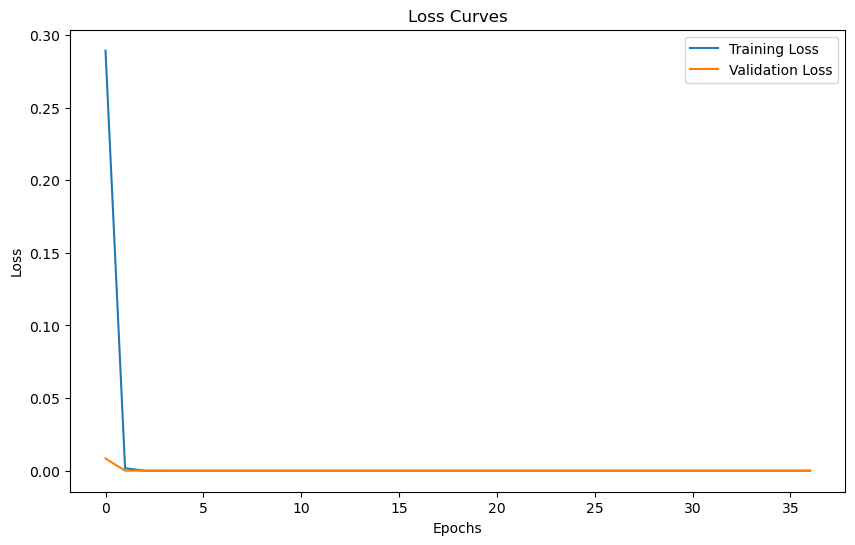

In [21]:
# Access the loss values from model.history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

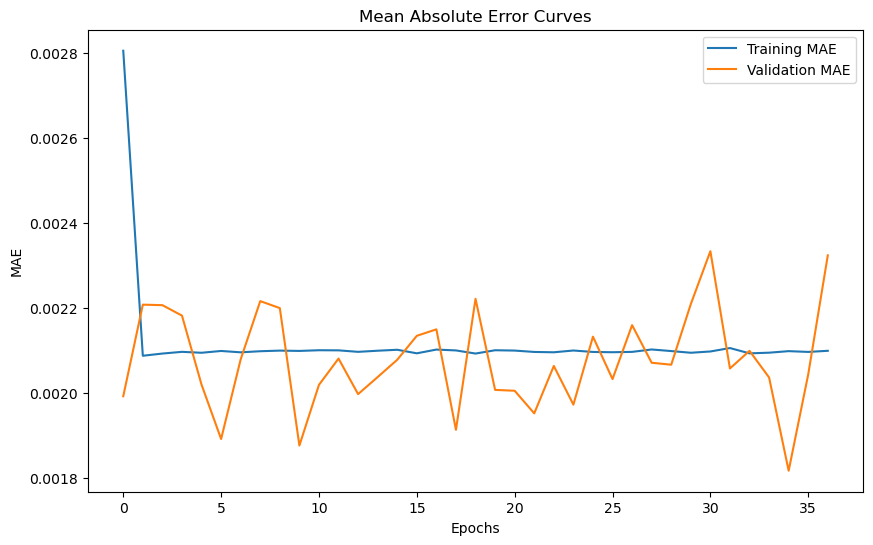

In [22]:
mae = history.history['mae']
val_mae = history.history['val_mae']

plt.figure(figsize=(10, 6))
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error Curves')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


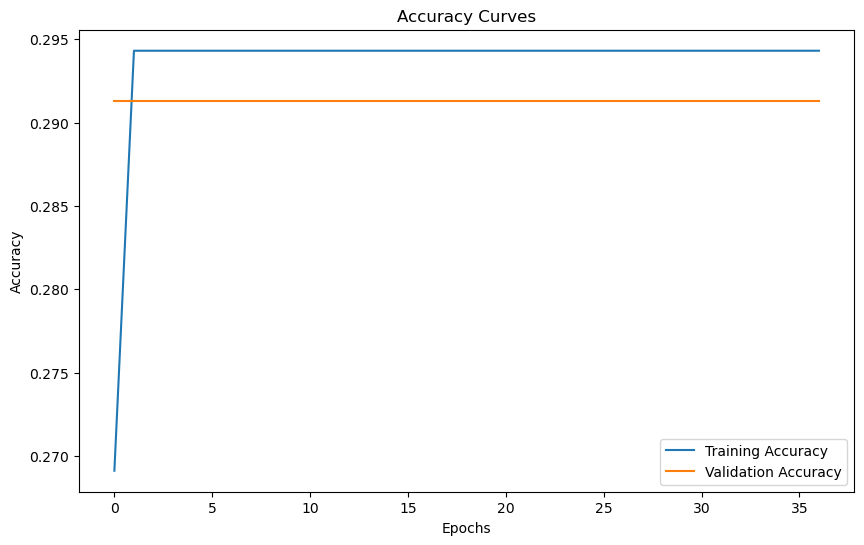

In [23]:
# Access the accuracy and val_accuracy values from history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy values
plt.figure(figsize=(10, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# Predict on new sequences (assuming you have X_test_reshaped as your new input data)
predicted_sequences = model.predict(X_test_reshaped)

88/88 [==============================] - 1s 5ms/step


In [25]:
predicted_sequences

array([[ 6.5395306e-03,  2.1726115e-02,  2.9878480e-02, ...,
        -1.5790334e-04,  8.9958087e-03,  5.9316597e-05],
       [ 6.5395306e-03,  2.1726115e-02,  2.9878480e-02, ...,
        -1.5790334e-04,  8.9958087e-03,  5.9316597e-05],
       [ 6.5395306e-03,  2.1726115e-02,  2.9878480e-02, ...,
        -1.5790334e-04,  8.9958087e-03,  5.9316597e-05],
       ...,
       [ 6.5395306e-03,  2.1726115e-02,  2.9878480e-02, ...,
        -1.5790334e-04,  8.9958087e-03,  5.9316597e-05],
       [ 6.5395306e-03,  2.1726115e-02,  2.9878480e-02, ...,
        -1.5790334e-04,  8.9958087e-03,  5.9316597e-05],
       [ 6.5395306e-03,  2.1726115e-02,  2.9878480e-02, ...,
        -1.5790334e-04,  8.9958087e-03,  5.9316597e-05]], dtype=float32)

In [26]:
# Reshape predicted_sequences to match the shape of the original sequences
predicted_sequences_reshaped = predicted_sequences.reshape(X_test_scaled.shape)

# Inverse transform the scaled predicted values to the original scale
predicted_sequences_original_scale = scaler.inverse_transform(predicted_sequences_reshaped)

In [27]:
predicted_sequences_original_scale

array([[ 3.5318156e-04,  1.4095649e-03,  1.1000787e-03, ...,
        -1.3833766e-06,  1.8673044e-04,  5.1362781e-07],
       [ 3.5318156e-04,  1.4095649e-03,  1.1000787e-03, ...,
        -1.3833766e-06,  1.8673044e-04,  5.1362781e-07],
       [ 3.5318156e-04,  1.4095649e-03,  1.1000787e-03, ...,
        -1.3833766e-06,  1.8673044e-04,  5.1362781e-07],
       ...,
       [ 3.5318156e-04,  1.4095649e-03,  1.1000787e-03, ...,
        -1.3833766e-06,  1.8673044e-04,  5.1362781e-07],
       [ 3.5318156e-04,  1.4095649e-03,  1.1000787e-03, ...,
        -1.3833766e-06,  1.8673044e-04,  5.1362781e-07],
       [ 3.5318156e-04,  1.4095649e-03,  1.1000787e-03, ...,
        -1.3833766e-06,  1.8673044e-04,  5.1362781e-07]], dtype=float32)

In [28]:
num_features

4984

In [29]:
predicted_sequences_words = tfidf_vectorizer.inverse_transform(predicted_sequences_original_scale)

In [30]:
reconstructed_sequences = ["".join(word) for word in predicted_sequences_words]

In [34]:
print(reconstructed_sequences[1])

aaaaaaaaaaacaaaaagaaaaanaaaaataaaacaaaaaccaaaacgaaaacnaaaactaaaagaaaaagcaaaaggaaaagnaaaagtaaaannaaaataaaaatcaaaatgaaaatnaaaattaaacaaaaacacaaacagaaacanaaacataaaccaaaacccaaaccgaaaccnaaacctaaacgaaaacgcaaacggaaacgtaaacnnaaactaaaactcaaactgaaactnaaacttaaagaaaaagacaaagagaaaganaaagataaagcaaaagccaaagctaaaggaaaaggcaaagggaaaggnaaaggtaaagnnaaagtaaaagtcaaagtgaaagtnaaagttaaannnaaataaaaatacaaatagaaatanaaatataaatcaaaatccaaatcgaaatctaaatgaaaatgcaaatggaaatgnaaatgtaaatnnaaattaaaattcaaattgaaattnaaatttaacaaaaacaacaacaagaacaanaacaataacacaaacaccaacacgaacacnaacactaacagaaacagcaacaggaacagnaacagtaacannaacataaacatcaacatgaacatnaacattaaccaaaaccacaaccagaaccanaaccataacccaaacccgaaccctaaccgaaaccgcaaccggaaccgtaaccnnaacctaaacctcaacctgaacctnaaccttaacgaaaacgagaacgataacgcaaacgccaacgctaacggaaacggcaacgggaacggtaacgnnaacgtaaacgtcaacgtgaacgttaacnnnaactaaaactacaactagaactataactcaaactccaactcgaactcnaactctaactgaaactgcaactggaactgtaactnnaacttaaacttcaacttgaacttnaactttaagaaaaagaacaagaagaagaanaagaataagacaaagaccaagacgaagactaagagaaagagcaaga

In [33]:
len(reconstructed_sequences[0])

29904